<a href="https://colab.research.google.com/github/akpanitorobong/7120CEM-Natural_Language_Processing/blob/main/7120_CW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Preparation**

**Neccessary Imports**

In [1]:

# 1. Install Required Libraries
!pip install -q emoji transformers datasets  # Install emoji and HuggingFace transformers libraries


# 2. Import Standard and External Libraries
import os  # File and directory operations
import re  # Regular expressions for text cleaning
import requests  # HTTP requests (e.g., downloading files)

import pandas as pd  # Data manipulation
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Enhanced data visualization
from wordcloud import WordCloud  # Word cloud generation



# 3. Import NLP Libraries
import nltk  # Natural Language Toolkit
from nltk.tokenize import word_tokenize  # Tokenizing text into words
from nltk.corpus import stopwords  # Common stop words

import spacy  # For advanced NLP tasks (e.g., lemmatization)
import emoji  # Emoji handling in text

# Download NLTK resources
nltk.download('punkt')  # Sentence/word tokenization
nltk.download('stopwords')  # Stopword list

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")  # Small English model for NLP tasks

# 4. Import PyTorch and Transformers Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset  # Data loading utilities

from transformers import BertTokenizer, BertModel, DistilBertTokenizerFast, DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments  # Pretrained BERT
from torch.optim import AdamW  # Optimizer for transformers


# 5. Utility Libraries for Evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split  # Train-test splitting
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # Evaluation metrics
# Correct import from the 'datasets' library
from datasets import Dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 3.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platfo

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Github, File Extensions & Folders**

In [2]:
repo_url = "https://api.github.com/repos/akpanitorobong/7120CEM-Natural_Language_Processing/contents/dataset2"
# URL of the GitHub repository folder

# Directory to store the downloaded files
local_folder = "/content/dataset/"
os.makedirs(local_folder, exist_ok=True)

# Valid file extensions
valid_extensions = {".txt", ".csv"}

**Download and Group Datasets**

In [3]:
# Function to download files from GitHub using raw URLs
def download_file(file_name, file_url):
    local_path = os.path.join(local_folder, file_name)
    response = requests.get(file_url)
    if response.status_code == 200:
        with open(local_path, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {file_name} to {local_path}")
    else:
        print(f"Failed to download {file_name}.")

# Get the list of files from the GitHub API
response = requests.get(repo_url)
if response.status_code == 200:
    files = response.json()

    # Categorize files into 2017, sarcasm, and regular
    files_sarcasm = []
    files_regular = []

    # Download and categorize files
    for file in files:
        file_name = file['name']
        file_extension = os.path.splitext(file_name)[1]

        # Proceed if the file has a valid extension
        if file_extension in valid_extensions:
            file_url = file['download_url']

            # Download the file
            download_file(file_name, file_url)

            # Categorize based on the file name
            if "sarcasm" in file_name:
                files_sarcasm.append(f"dataset/{file_name}")
            else:
                files_regular.append(f"dataset/{file_name}")

    # Print categorized files for confirmation
    print("Sarcasm Files:", files_sarcasm)
    print("Regular Files:", files_regular)

else:
    print(f"Failed to fetch file list from the repository. Status Code: {response.status_code}")

Downloaded twitter-2014sarcasm-A.txt to /content/dataset/twitter-2014sarcasm-A.txt
Downloaded twitter-2014test-A.txt to /content/dataset/twitter-2014test-A.txt
Sarcasm Files: ['dataset/twitter-2014sarcasm-A.txt']
Regular Files: ['dataset/twitter-2014test-A.txt']


# **Preprocess Datasets**

**Inspect Datasets**

In [4]:
with open(files_sarcasm[0], 'r', encoding='utf-8') as f:
    for _ in range(10):  # Adjust the number to preview more lines
        print(f.readline().strip())

434314703540846592	negative	"@MetroNorth wall to wall people on the platform at South Norwalk waiting for the 8:08. Thanks for the Sat. Sched. Great sense
437605331414573056	neutral	ang sarap mging panganay. Pag ikaw may kylngan wala kang matakbuhan.:D 101 #realtalk #grind #onyourown"
437424096238792704	negative	"RT @katie_rohaley: School on Monday is just gonna be a great time
436835928733388800	negative	Thanks manager for putting me on the schedule for Sunday"
435670962327941120	negative	"Who needs sleep? It's not like I have a test tomorrow or anything...
426860451176402944	positive	1st opening shift in quite a while... This should be interesting."
436698945432326144	neutral	"@rob_yost -Hashtags can express humor, excitement- ex: ""Just found out my mom is my teacher. #awkward"" or ""It's Monday! #excited ""
430770577838968832	negative	it's supposed to snow from midnight tonight until 6pm tomorrow? oh well that's friggin awesome"
428714340964130816	positive	"Grades come out tomorrow

**File Parser**

In [5]:
def parse_tweet_file(filepath):
    """
    Reads a tweet dataset file and returns a DataFrame with columns: id, sentiment, text.
    Handles multi-line tweets.
    """
    data = []
    buffer = None

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')

            if len(parts) == 3:
                if buffer:
                    data.append(buffer)
                buffer = parts
            elif len(parts) == 1 and buffer:
                buffer[2] += ' ' + parts[0]  # continuation line
        if buffer:
            data.append(buffer)

    df = pd.DataFrame(data, columns=['id', 'sentiment', 'text'])
    return df

**Parse Files**

In [6]:
all_sarcasm_dfs = [parse_tweet_file(fp) for fp in files_sarcasm]
all_regular_dfs = [parse_tweet_file(fp) for fp in files_regular]
df_sarcasm = pd.concat(all_sarcasm_dfs, ignore_index=True)
df_regular = pd.concat(all_regular_dfs, ignore_index=True)

df_sarcasm.head()

,id,sentiment,text
0,434314703540846592,negative,"""@MetroNorth wall to wall people on the platfo..."
1,437605331414573056,neutral,ang sarap mging panganay. Pag ikaw may kylngan...
2,437424096238792704,negative,"""RT @katie_rohaley: School on Monday is just g..."
3,436835928733388800,negative,Thanks manager for putting me on the schedule ...
4,435670962327941120,negative,"""Who needs sleep? It's not like I have a test ..."


In [7]:
df_sarcasm.value_counts('sentiment')

,count
sentiment,
negative,40
positive,33
neutral,13


**Clean Text Function**

In [8]:
# Function to remove emojis using regular expressions
def remove_emojis(text):
    # Regex pattern to match emojis
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Function to replace emoticons with a sentiment label
def replace_emoticons(text):
    # Emoticons mapping (you can expand this list)
    emoticons_dict = {
        ":)": "happy",
        ":(": "sad",
        ":D": "happy",
        ":-)": "happy",
        ":-(": "sad",
        "XD": "happy",
        ":'(": "sad",
        ":P": "playful",
        ";)": "wink",
        ":o": "surprised",
        "O:(": "angry",
        ">:(": "angry",
        "T_T": "sad"
    }

    for emoticon, sentiment in emoticons_dict.items():
        text = text.replace(emoticon, sentiment)

    return text

def clean_text(text):
    """
    Clean the tweet text:
    - Lowercasing
    - Removing URLs
    - Removing mentions (@user)
    - Removing non-alphanumeric characters (except hashtags, emojis, punctuation)
    - Removing stopwords
    - Lemmatizing words
    - Stripping extra whitespace
    - Removing retweets
    - Removing emojis and emoticons
    """
    # Lowercase the text
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove mentions (@user)
    text = re.sub(r'@\w+', '', text)

    # Remove retweet (RT @user)
    text = re.sub(r'\b(rt|RT)\b', '', text)

    # Remove emojis
    text = remove_emojis(text)

    # Replace emoticons like ":)" and ":("
    text = replace_emoticons(text)

    # Remove non-alphanumeric characters, except for hashtags, emojis, and punctuation
    text = re.sub(r'[^a-zA-Z0-9\s#.,!?\'":;()]', '', text)

    # Tokenize the text using spaCy
    doc = nlp(text)

    # Remove stopwords and lemmatize the words
    text = " ".join([token.lemma_ for token in doc if token.text not in stopwords.words('english') and not token.is_punct])

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

**Compare Before and After Text Cleaning**

Before

In [9]:
print("Raw DataFrame (Before Cleaning):")
df_sarcasm.head()

Raw DataFrame (Before Cleaning):


,id,sentiment,text
0,434314703540846592,negative,"""@MetroNorth wall to wall people on the platfo..."
1,437605331414573056,neutral,ang sarap mging panganay. Pag ikaw may kylngan...
2,437424096238792704,negative,"""RT @katie_rohaley: School on Monday is just g..."
3,436835928733388800,negative,Thanks manager for putting me on the schedule ...
4,435670962327941120,negative,"""Who needs sleep? It's not like I have a test ..."


After

In [10]:
# Apply cleaning to the 'text' column
df_sarcasm['text'] = df_sarcasm['text'].apply(clean_text)
print("\nCleaned DataFrame (After Applying `clean_text`):")
df_sarcasm.head()


Cleaned DataFrame (After Applying `clean_text`):


,id,sentiment,text
0,434314703540846592,negative,wall wall people platform south norwalk wait 8...
1,437605331414573056,neutral,ang sarap mge panganay pag ikaw may kylngan wa...
2,437424096238792704,negative,school monday go to great time
3,436835928733388800,negative,thank manager put schedule sunday
4,435670962327941120,negative,need sleep be like test tomorrow anything


**Dataframe Level Cleaning**

In [11]:
def clean_dataframe(df):
    """
    Perform DataFrame-level cleaning:
    - Drop 'id' column
    - Handle NaN values (drop or fill)
    - Drop Duplicate Values
    - Reset the index
    - Categorical Encoding
    """
    # Drop the 'id' column
    df = df.drop(columns=['id'])

    if df.isna().any().any():
        print(f"{df.isna.count()}NaN values found in the DataFrame.")
        # Handle NaN values (drop or fill)
        df = df.dropna()
    else:
        print("No NaN values found in the DataFrame.")

    # Handle duplicates
    if df.duplicated().any():
        print(f"{df.duplicated().sum()} duplicate rows found in the DataFrame.")
        # Drop duplicate rows
        df = df.drop_duplicates()
        print("Duplicate rows dropped.")
    else:
        print("No duplicates found in the DataFrame.")

    # Reset index after dropping rows
    df.reset_index(drop=True, inplace=True)

    # Categorical Encoding
    df['label'] = df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

    return df

In [12]:
df_sarcasm = clean_dataframe(df_sarcasm)
df_regular = clean_dataframe(df_regular)

df_sarcasm.head()

No NaN values found in the DataFrame.
No duplicates found in the DataFrame.
No NaN values found in the DataFrame.
No duplicates found in the DataFrame.


,sentiment,text,label
0,negative,wall wall people platform south norwalk wait 8...,0
1,neutral,ang sarap mge panganay pag ikaw may kylngan wa...,1
2,negative,school monday go to great time,0
3,negative,thank manager put schedule sunday,0
4,negative,need sleep be like test tomorrow anything,0


In [13]:
df_sarcasm.value_counts('label')

,count
label,
0,40
2,33
1,13


# **Exploratory Data Analysis**

**Basic Overview of the Data**

In [14]:
# Check the first few rows and basic information
print(df_sarcasm.info())
print(df_regular.info())

print(df_sarcasm.head())
print(df_regular.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  86 non-null     object
 1   text       86 non-null     object
 2   label      86 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1853 entries, 0 to 1852
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  1853 non-null   object
 1   text       1853 non-null   object
 2   label      1853 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 43.6+ KB
None
  sentiment                                               text  label
0  negative  wall wall people platform south norwalk wait 8...      0
1   neutral  ang sarap mge panganay pag ikaw may kylngan wa...      1
2  negative                     school monday go to great time      0
3  negative

**Sentiment Distribution**

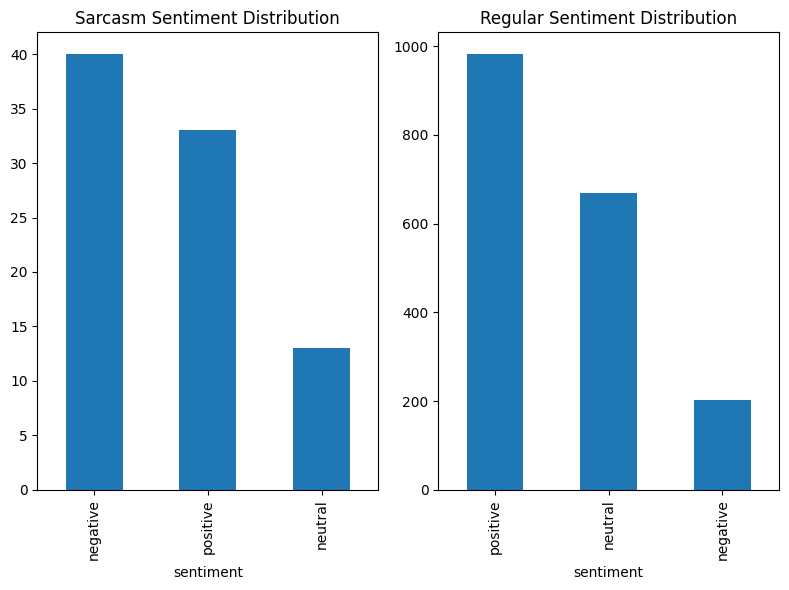

In [15]:
# Plot sentiment distribution for each dataframe
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
df_sarcasm['sentiment'].value_counts().plot(kind='bar', title='Sarcasm Sentiment Distribution')

plt.subplot(1, 3, 2)
df_regular['sentiment'].value_counts().plot(kind='bar', title='Regular Sentiment Distribution')

plt.tight_layout()
plt.show()

**Text Length Distribution**

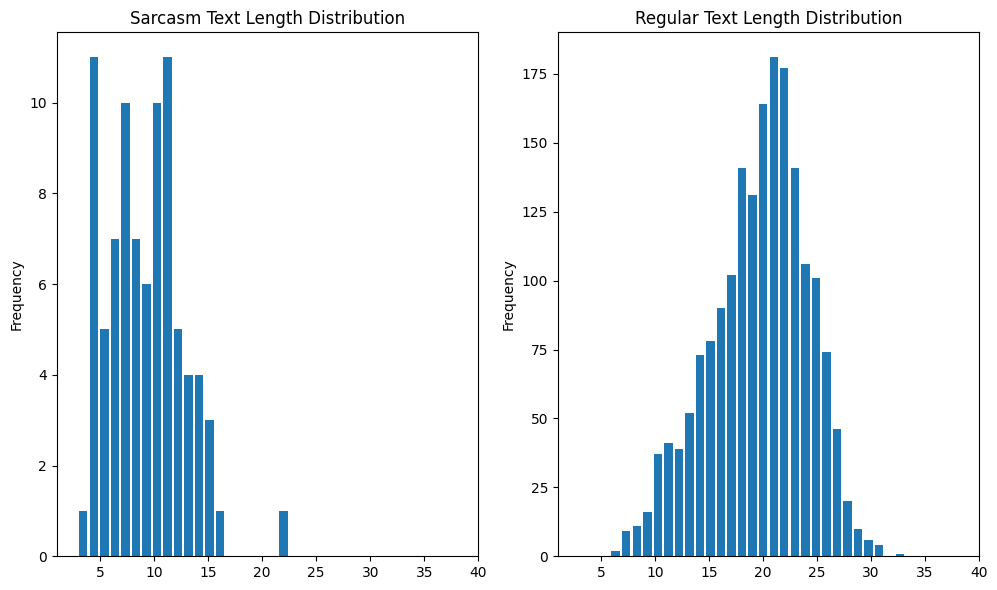

In [16]:
import matplotlib.pyplot as plt

# Create a function to calculate text length
df_sarcasm['text_length'] = df_sarcasm['text'].apply(lambda x: len(x.split()))  # Word count
df_regular['text_length'] = df_regular['text'].apply(lambda x: len(x.split()))

# Increase figure size and adjust layout
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
df_sarcasm['text_length'].plot(kind='hist', bins=40, range=(1, 40), rwidth=0.8, title='Sarcasm Text Length Distribution')
plt.xlim(1, 40)

plt.subplot(1, 3, 2)
df_regular['text_length'].plot(kind='hist', bins=40, range=(1, 40), rwidth=0.8, title='Regular Text Length Distribution')
plt.xlim(1, 40)

# Adjust the layout for more spacing between plots
plt.subplots_adjust(wspace=0.4)  # Increase horizontal space between plots

plt.tight_layout()
plt.show()

**Word Cloud**

Word Cloud for Sarcasm:


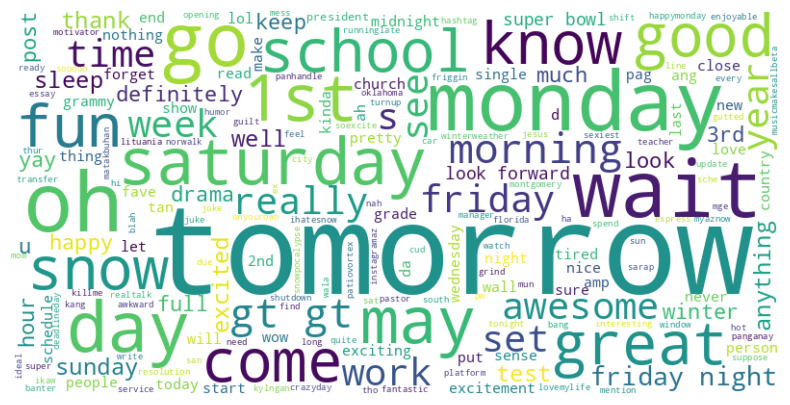


Word Cloud for Regular:


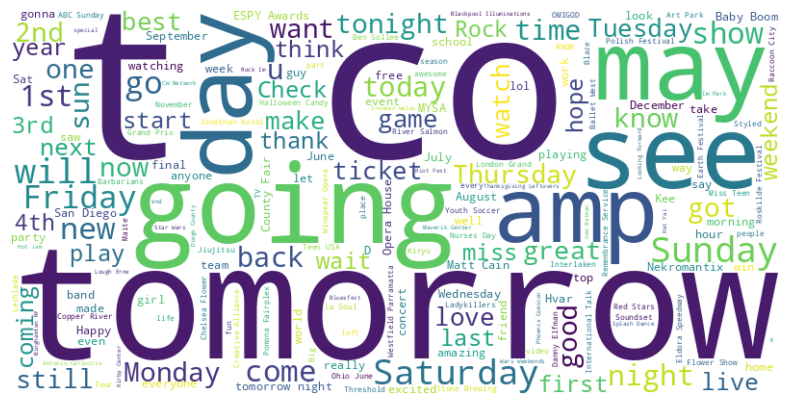

In [17]:
def plot_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Plot word clouds for each dataset
print("Word Cloud for Sarcasm:")
plot_wordcloud(df_sarcasm['text'])
print("\nWord Cloud for Regular:")
plot_wordcloud(df_regular['text'])

**Check for Class Imbalance**

In [18]:
# Calculate and display class proportions for each dataset
print("Sarcasm dataset class proportions:")
print(df_sarcasm['label'].value_counts(normalize=True))

print("\nRegular dataset class proportions:")
print(df_regular['label'].value_counts(normalize=True))

Sarcasm dataset class proportions:
label
0    0.465116
2    0.383721
1    0.151163
Name: proportion, dtype: float64

Regular dataset class proportions:
label
2    0.529951
1    0.361036
0    0.109012
Name: proportion, dtype: float64


# **Dataset Combination, Feature Augmentation and Splitting**

In [19]:
# Add 'sarcastic' flag
df_sarcasm['sarcastic'] = 1
df_regular['sarcastic'] = 0

# Combine and shuffle
df_combined = pd.concat([df_sarcasm, df_regular], ignore_index=True)
df_combined = df_combined.sample(frac=.5, random_state=42).reset_index(drop=True)

# Feature and label split
X = df_combined[['text']]
y_sentiment = df_combined['label']
y_sarcasm = df_combined['sarcastic']

# Stratified split
stratify_combo = df_combined[['label', 'sarcastic']].apply(tuple, axis=1)
X_train, X_test, y_sentiment_train, y_sentiment_test, y_sarcasm_train, y_sarcasm_test = train_test_split(
    X, y_sentiment, y_sarcasm, test_size=0.3, stratify=stratify_combo, random_state=42
)

# Build DataFrames
train_data = pd.concat([X_train.reset_index(drop=True),
                        y_sentiment_train.reset_index(drop=True),
                        y_sarcasm_train.reset_index(drop=True)], axis=1)

test_data = pd.concat([X_test.reset_index(drop=True),
                       y_sentiment_test.reset_index(drop=True),
                       y_sarcasm_test.reset_index(drop=True)], axis=1)

# Encode sentiment labels
label_encoder = LabelEncoder()
train_data["label_encoded"] = label_encoder.fit_transform(train_data["label"])
test_data["label_encoded"] = label_encoder.transform(test_data["label"])

**Print Shape**

In [20]:
print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Train class distribution (sentiment):")
print(train_data['label'].value_counts())
print("Train sarcasm distribution:")
print(train_data['sarcastic'].value_counts())
print("Test class distribution (sentiment):")
print(test_data['label'].value_counts())
print("Test sarcasm distribution:")
print(test_data['sarcastic'].value_counts())

Train shape: (679, 4)
Test shape: (291, 4)
Train class distribution (sentiment):
label
2    356
1    239
0     84
Name: count, dtype: int64
Train sarcasm distribution:
sarcastic
0    652
1     27
Name: count, dtype: int64
Test class distribution (sentiment):
label
2    153
1    102
0     36
Name: count, dtype: int64
Test sarcasm distribution:
sarcastic
0    279
1     12
Name: count, dtype: int64


# **Moddel Training**

**Sarcasm Classification Model**

In [21]:
# Create a sarcasm detection dataset from pandas DataFrame
sarcasm_dataset = Dataset.from_pandas(train_data[['text', 'sarcastic']])

# Rename 'sarcastic' column to 'labels' for consistency
sarcasm_dataset = sarcasm_dataset.rename_columns({'sarcastic': 'labels'})

# Initialize the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Tokenize the dataset
sarcasm_dataset = sarcasm_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length'), batched=True)
sarcasm_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Check the dataset
sarcasm_dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/679 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 679
})

In [22]:
# Initialize tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Create a sarcasm detection dataset from pandas DataFrame
sarcasm_dataset = Dataset.from_pandas(train_data[['text', 'sarcastic']])

# Rename 'sarcastic' column to 'labels' for consistency
sarcasm_dataset = sarcasm_dataset.rename_columns({'sarcastic': 'labels'})

# Tokenize the dataset
sarcasm_dataset = sarcasm_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length'), batched=True)
sarcasm_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Check the dataset
sarcasm_dataset

# Split dataset for training and testing
sarcasm_split = sarcasm_dataset.train_test_split(test_size=0.3, seed=42)

# Initialize the sarcasm classification model
model_sarcasm = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Define training arguments
sarcasm_args = TrainingArguments(
    output_dir="./sarcasm_model",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    num_train_epochs=3,
    save_strategy="no",
    logging_dir="./logs",
)

# Initialize the Trainer
trainer_sarcasm = Trainer(
    model=model_sarcasm,
    args=sarcasm_args,
    train_dataset=sarcasm_split["train"],
    eval_dataset=sarcasm_split["test"]
)



# Train the sarcasm model
trainer_sarcasm.train()

Map:   0%|          | 0/679 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: akpanitorobong (akpanitorobong-coventry-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,0.031756
2,No log,0.003219
3,No log,0.002255


TrainOutput(global_step=90, training_loss=0.06203976207309299, metrics={'train_runtime': 5333.4973, 'train_samples_per_second': 0.267, 'train_steps_per_second': 0.017, 'total_flos': 188766043084800.0, 'train_loss': 0.06203976207309299, 'epoch': 3.0})

**Sentiment Model - Baseline**

In [23]:
# Create the sentiment analysis dataset
sentiment_dataset = Dataset.from_pandas(train_data[['text', 'label_encoded']])
sentiment_dataset = sentiment_dataset.rename_columns({'label_encoded': 'labels'})
sentiment_dataset = sentiment_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length'), batched=True)
sentiment_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Split dataset for training and testing
sentiment_split = sentiment_dataset.train_test_split(test_size=0.3, seed=42)

# Initialize the sentiment classification model
model_sentiment = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Define Trainer for sentiment model
trainer_sent = Trainer(
    model=model_sentiment,
    args=sarcasm_args,
    train_dataset=sentiment_split["train"],
    eval_dataset=sentiment_split["test"]
)

# Train the sentiment model
trainer_sent.train()

Map:   0%|          | 0/679 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.926777


Epoch,Training Loss,Validation Loss
1,No log,0.926777
2,No log,0.827060
3,No log,0.806289


TrainOutput(global_step=90, training_loss=0.766121334499783, metrics={'train_runtime': 5016.0708, 'train_samples_per_second': 0.284, 'train_steps_per_second': 0.018, 'total_flos': 188769409459200.0, 'train_loss': 0.766121334499783, 'epoch': 3.0})

**Sentiment Model - Text Augmented with Sarcasm Scores**

In [24]:
# Function to augment text with sarcasm probability
def add_sarcasm_token(row):
    inputs = tokenizer(row['text'], return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits = model_sarcasm(**inputs).logits
    prob = torch.nn.functional.softmax(logits, dim=-1)[0][1].item()  # Probability of sarcasm
    return f"[SARCASM={round(prob, 2)}] {row['text']}"

# Augment the text data with sarcasm probability
train_data['text_aug'] = train_data.apply(add_sarcasm_token, axis=1)
test_data['text_aug'] = test_data.apply(add_sarcasm_token, axis=1)

# Create a new augmented dataset for sentiment analysis
sentiment_dataset_aug = Dataset.from_pandas(train_data[['text_aug', 'label_encoded']])
sentiment_dataset_aug = sentiment_dataset_aug.rename_columns({'label_encoded': 'labels'})
sentiment_dataset_aug = sentiment_dataset_aug.map(lambda e: tokenizer(e['text_aug'], truncation=True, padding='max_length'), batched=True)
sentiment_dataset_aug.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Initialize augmented sentiment classification model
model_sentiment_aug = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Define Trainer for augmented sentiment model
trainer_sent_aug = Trainer(
    model=model_sentiment_aug,
    args=sarcasm_args,
    train_dataset=sentiment_dataset_aug,
    eval_dataset=sentiment_split["test"]
)

# Train the augmented sentiment model
trainer_sent_aug.train()

Map:   0%|          | 0/679 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.784477


Epoch,Training Loss,Validation Loss
1,No log,0.784477
2,No log,0.463854
3,No log,0.367589


TrainOutput(global_step=129, training_loss=0.6859036231225775, metrics={'train_runtime': 6994.548, 'train_samples_per_second': 0.291, 'train_steps_per_second': 0.018, 'total_flos': 269840903205888.0, 'train_loss': 0.6859036231225775, 'epoch': 3.0})

**Evaluation**

In [25]:
# Function to evaluate a trained model on a given dataset
def evaluate_model(trainer, dataset, true_labels, label_names):
    preds = trainer.predict(dataset)
    y_pred = preds.predictions.argmax(axis=1)
    print(classification_report(true_labels, y_pred, target_names=label_names))

# Convert label names to strings
label_names = [str(label) for label in label_encoder.classes_]

# Tokenize test set for sarcasm-aware evaluation
test_aug = Dataset.from_pandas(test_data[['text_aug', 'label_encoded']])
test_aug = test_aug.map(lambda e: tokenizer(e['text_aug'], truncation=True, padding='max_length'), batched=True)
test_aug.set_format(type='torch', columns=['input_ids', 'attention_mask'])

# Evaluate the augmented sentiment model
evaluate_model(trainer_sent_aug, test_aug, test_data["label_encoded"].values, label_names)

Map:   0%|          | 0/291 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           0       0.50      0.39      0.44        36
           1       0.71      0.64      0.67       102
           2       0.76      0.86      0.81       153

    accuracy                           0.72       291
   macro avg       0.66      0.63      0.64       291
weighted avg       0.71      0.72      0.71       291



In [31]:
# Print the first few entries in log_history
for log in trainer_sent_aug.state.log_history[:10]:
    print(log)

# Try different keys if 'loss' doesn't exist
loss_values = [
    log.get('loss') or log.get('eval_loss')
    for log in trainer_sent_aug.state.log_history
    if 'loss' in log or 'eval_loss' in log
]

{'eval_loss': 0.7844770550727844, 'eval_runtime': 182.9444, 'eval_samples_per_second': 1.115, 'eval_steps_per_second': 0.142, 'epoch': 1.0, 'step': 43}
{'eval_loss': 0.4638538658618927, 'eval_runtime': 185.7718, 'eval_samples_per_second': 1.098, 'eval_steps_per_second': 0.14, 'epoch': 2.0, 'step': 86}
{'eval_loss': 0.36758872866630554, 'eval_runtime': 183.6948, 'eval_samples_per_second': 1.111, 'eval_steps_per_second': 0.142, 'epoch': 3.0, 'step': 129}
{'train_runtime': 6994.548, 'train_samples_per_second': 0.291, 'train_steps_per_second': 0.018, 'total_flos': 269840903205888.0, 'train_loss': 0.6859036231225775, 'epoch': 3.0, 'step': 129}


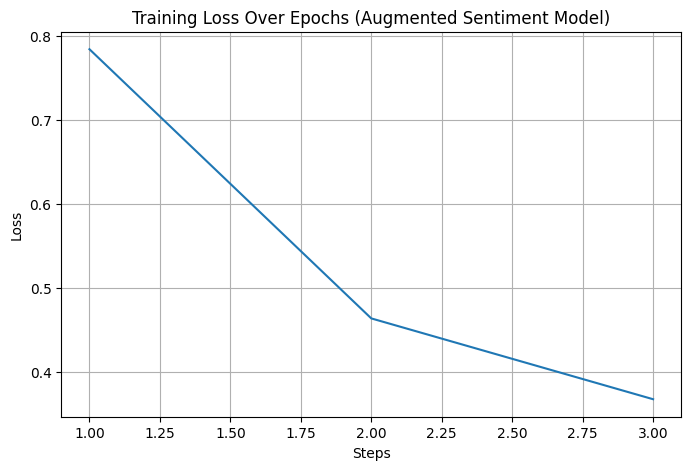

In [33]:
# Extract the training loss values from log_history
loss_values = [log['eval_loss'] for log in trainer_sent_aug.state.log_history if 'eval_loss' in log]

# Plot the training loss
if loss_values:
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(loss_values) + 1), loss_values)
    plt.title("Training Loss Over Epochs (Augmented Sentiment Model)")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
else:
    print("No loss values found in trainer_sent_aug.state.log_history.")

In [ ]:
from sklearn.metrics import classification_report

# Make predictions on the test set
predictions = trainer_sarcasm.predict(sarcasm_split["test"])

# Get predicted labels
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

# Generate classification report
print(classification_report(labels, preds, target_names=["Not Sarcastic", "Sarcastic"]))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Sarcastic", "Sarcastic"], yticklabels=["Not Sarcastic", "Sarcastic"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Sarcasm Detection")
plt.show()
